### Imports

In [1]:
include("layers.jl")
include("utils.jl")
include("vae.jl")
using .Utils, .Layers, .VAE

using Flux
using LightGraphs
using Colors
using AbstractPlotting
using Makie
using CairoMakie
using BSON: @load
using NPZ
using Random
using StatsBase
using Distributions

## Loading the dataset

In [2]:
function dataset(args)
    data = npzread(args["dataset"])

    features = convert(Array{Float32}, transpose(data["features"]))
    classes = transpose(data["labels"])

    # Make sure we have a non-weighted graph
    @assert Set(data["adjdata"]) == Set([1])

    # Remove any diagonal elements in the matrix
    rows = data["adjrow"]
    cols = data["adjcol"]
    nondiagindices = findall(rows .!= cols)
    rows = rows[nondiagindices]
    cols = cols[nondiagindices]
    # Make sure indices start at 0
    @assert minimum(rows) == minimum(cols) == 0

    # Construct the graph
    edges = LightGraphs.SimpleEdge.(1 .+ rows, 1 .+ cols)
    g = SimpleGraphFromIterator(edges)

    # Check sizes for sanity
    @assert nv(g) == size(g, 1) == size(g, 2) == size(features, 2)

    # Randomize to the level requested
    nnodes = nv(g)
    correlation = args["forced-correlation"]
    nshuffle = Int(round((1 - correlation) * nnodes))
    idx = StatsBase.sample(1:nnodes, nshuffle, replace = false)
    shuffledidx = shuffle(idx)
    features[:, idx] = features[:, shuffledidx]
    classes[:, idx] = classes[:, shuffledidx]

    @assert eltype(features) == Float32
    g, features, classes
end

dataset (generic function with 1 method)

### Plotting model state

In [3]:
adims(a, dims) = [a[i, :] for i = dims]

function plotstate(;enc, vae, x, refx, g, dims, colors)
    @assert length(dims) in [2, 3]
    embμ, emblogσ = enc(x)
    logitÂ, unormF̂ = vae(x)
    hbox(
        vbox(
            Scene(),
            heatmap(σ.(logitÂ).data, colorrange = (0, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), softmax(unormF̂).data, colorrange = (0, 1)),
            sizes = [.45, .45, .1]
        ),
        vbox(
            scatter(adims(embμ, dims)..., color = colors, markersize = Utils.markersize(embμ)),
            heatmap(Array(adjacency_matrix(g)), colorrange = (0, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), refx, colorrange = (0, 1)),
            sizes = [.45, .45, .1]
        ),
    )
end

function plotweights(layers...)
    theme = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
    vbox([hbox(heatmap(l.W.data), text(theme, repr(l))) for l in layers]...)
end

plotweights (generic function with 1 method)

## Model parameters

In [4]:
args = Dict(
    "dataset" => "/home/etron/160606H20-160807T06_twrtw/160606H20-160807T06_twrtw_T5.npz",
    "forced-correlation" => 1.0, # default
    "label-distribution" => VAE.label_distributions["bernoulli"],
    "diml1enc" => 100,
    "diml1dec" => 100,
    "dimxiadj" => 16,
    "dimxifeat" => 16,
    "overlap" => 8,
    "bias" => false,
    "sharedl1" => false,
    "decadjdeep" => true,
    "initb" => VAE.Layers.nobias
)

Dict{String,Any} with 12 entries:
  "diml1dec"           => 100
  "sharedl1"           => false
  "label-distribution" => Bernoulli
  "diml1enc"           => 100
  "bias"               => false
  "overlap"            => 8
  "initb"              => nobias
  "decadjdeep"         => true
  "dimxiadj"           => 16
  "dataset"            => "/home/etron/160606H20-160807T06_twrtw/160606H20-1608…
  "forced-correlation" => 1.0
  "dimxifeat"          => 16

### Load the model and plot its state

In [5]:
g, _features, _ = dataset(args)
labels = _features
feature_size = size(_features, 1)
label_size = feature_size
fnormalise = Utils.normaliser(_features)
features = fnormalise(_features);

In [6]:
@load "/home/etron/160606H20-160807T06_twrtw/160606H20-160807T06_twrtw_weights_T5_dimxiadj=16_dimxifeat=16_overlap=8.bson" weights args

enc, sampleξ, dec, paramsenc, paramsdec = VAE.make_vae(
    g = g, feature_size = feature_size, label_size = label_size, args = args)
vae(x) = dec(sampleξ(enc(x)...))

paramsvae = Tracker.Params()
push!(paramsvae, paramsenc..., paramsdec...)
loadparams!(paramsvae, weights)

Info: using unshared l1 encoder
Info: using deep adjacency decoder
Info: using boolean feature decoder


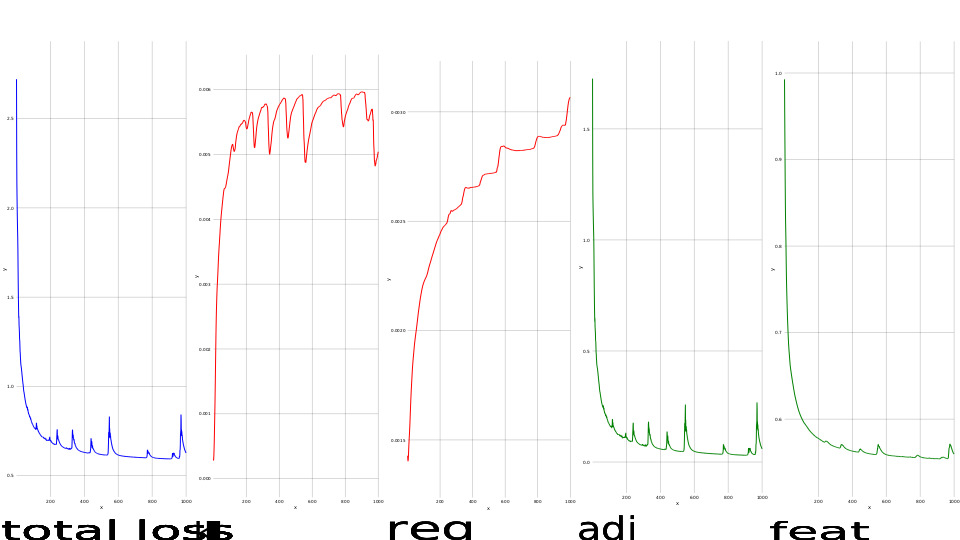

In [7]:
history = npzread("/home/etron/160606H20-160807T06_twrtw/160606H20-160807T06_twrtw_training-history_T5_dimxiadj=16_dimxifeat=16_overlap=8.npz")

theme = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
scene = vbox([hbox(lines(1:length(history[name]), history[name], color = color), text(theme, name))
        for (name, color) in [
                ("total loss", :blue),
                ("kl", :red),
                ("reg", :red),
                ("adj", :green),
                ("feat", :green),
                #("ap", :cyan),
                #("auc", :cyan)
            ]]...)
Makie.save("training-history.png", scene)
scene

In [ ]:
#communities = [c for c in 1:args["l"] for i in 1:args["k"]]
#palette = distinguishable_colors(args["l"])
#colors = map(i -> getindex(palette, i), communities)

plotstate(enc = enc, vae = vae, x = _features, refx = labels,
    g = g, dims = 1:3, colors = "black")

In [9]:
embμ, emblogσ = enc(features)
logitÂ, unormF̂ = vae(features);

(Float32[3.68189 -17.2544 … -16.6082 -22.5394; -16.9809 4.94767 … 1.40471 -5.7364; … ; -16.6236 1.2688 … 3.62455 -0.860944; -23.1756 -6.04736 … -0.646846 4.35305] (tracked), Float32[2.63922 -1.0644 … -0.761673 0.161458; -0.336856 -0.437799 … -0.263817 -1.58264; … ; -6.10622 -3.0193 … -1.92362 -4.28723; -1.2227 0.387459 … 0.879341 0.673227] (tracked))

In [10]:
# Adjacency reconstruction
scene = Scene(resolution = (15000, 15000))
heatmap!(scene, σ.(logitÂ).data, colorrange = (0, 1))
Makie.save("Apred.png", scene);

(CairoMakie.CairoBackend(SVG::RenderType = 0, "/tmp/tmpmIRtrN/cairo.svg"), Scene(nothing, Events(Observable{GeometryTypes.HyperRectangle{2,Int64}} with 1 listeners. Value:
GeometryTypes.HyperRectangle{2,Int64}([0, 0], [0, 0]), Observable{Float64} with 0 listeners. Value:
100.0, Observable{Bool} with 0 listeners. Value:
false, Observable{Set{AbstractPlotting.Mouse.Button}} with 0 listeners. Value:
Set(AbstractPlotting.Mouse.Button[]), Observable{Tuple{Float64,Float64}} with 0 listeners. Value:
(0.0, 0.0), Observable{AbstractPlotting.Mouse.DragEnum} with 2 listeners. Value:
notpressed::DragEnum = 3, Observable{Tuple{Float64,Float64}} with 1 listeners. Value:
(0.0, 0.0), Observable{Set{AbstractPlotting.Keyboard.Button}} with 0 listeners. Value:
Set(AbstractPlotting.Keyboard.Button[]), Observable{Array{Char,1}} with 0 listeners. Value:
Char[], Observable{Array{String,1}} with 0 listeners. Value:
String[], Observable{Bool} with 0 listeners. Value:
false, Observable{Bool} with 0 listeners. V

In [11]:
# Adjacency reference
scene = Scene(resolution = (15000, 15000))
heatmap!(scene, Array(adjacency_matrix(g)), colorrange = (0, 1))
Makie.save("Aref.png", scene);

(CairoMakie.CairoBackend(SVG::RenderType = 0, "/tmp/tmpmIRtrN/cairo.svg"), Scene(nothing, Events(Observable{GeometryTypes.HyperRectangle{2,Int64}} with 1 listeners. Value:
GeometryTypes.HyperRectangle{2,Int64}([0, 0], [0, 0]), Observable{Float64} with 0 listeners. Value:
100.0, Observable{Bool} with 0 listeners. Value:
false, Observable{Set{AbstractPlotting.Mouse.Button}} with 0 listeners. Value:
Set(AbstractPlotting.Mouse.Button[]), Observable{Tuple{Float64,Float64}} with 0 listeners. Value:
(0.0, 0.0), Observable{AbstractPlotting.Mouse.DragEnum} with 2 listeners. Value:
notpressed::DragEnum = 3, Observable{Tuple{Float64,Float64}} with 1 listeners. Value:
(0.0, 0.0), Observable{Set{AbstractPlotting.Keyboard.Button}} with 0 listeners. Value:
Set(AbstractPlotting.Keyboard.Button[]), Observable{Array{Char,1}} with 0 listeners. Value:
Char[], Observable{Array{String,1}} with 0 listeners. Value:
String[], Observable{Bool} with 0 listeners. Value:
false, Observable{Bool} with 0 listeners. V

In [12]:
# Feature reconstruction
scene = Scene(resolution = (150, 15000))
heatmap!(scene, 1:size(_features, 1), 1:size(_features, 2), softmax(unormF̂).data, colorrange = (0, 1))
Makie.save("Fpred.png", scene);

(CairoMakie.CairoBackend(SVG::RenderType = 0, "/tmp/tmpmIRtrN/cairo.svg"), Scene(nothing, Events(Observable{GeometryTypes.HyperRectangle{2,Int64}} with 1 listeners. Value:
GeometryTypes.HyperRectangle{2,Int64}([0, 0], [0, 0]), Observable{Float64} with 0 listeners. Value:
100.0, Observable{Bool} with 0 listeners. Value:
false, Observable{Set{AbstractPlotting.Mouse.Button}} with 0 listeners. Value:
Set(AbstractPlotting.Mouse.Button[]), Observable{Tuple{Float64,Float64}} with 0 listeners. Value:
(0.0, 0.0), Observable{AbstractPlotting.Mouse.DragEnum} with 2 listeners. Value:
notpressed::DragEnum = 3, Observable{Tuple{Float64,Float64}} with 1 listeners. Value:
(0.0, 0.0), Observable{Set{AbstractPlotting.Keyboard.Button}} with 0 listeners. Value:
Set(AbstractPlotting.Keyboard.Button[]), Observable{Array{Char,1}} with 0 listeners. Value:
Char[], Observable{Array{String,1}} with 0 listeners. Value:
String[], Observable{Bool} with 0 listeners. Value:
false, Observable{Bool} with 0 listeners. V

In [13]:
# Feature reference
scene = Scene(resolution = (150, 15000))
heatmap(1:size(_features, 1), 1:size(_features, 2), _features, colorrange = (0, 1))
Makie.save("Fref.png", scene);

(CairoMakie.CairoBackend(SVG::RenderType = 0, "/tmp/tmpmIRtrN/cairo.svg"), Scene(nothing, Events(Observable{GeometryTypes.HyperRectangle{2,Int64}} with 1 listeners. Value:
GeometryTypes.HyperRectangle{2,Int64}([0, 0], [0, 0]), Observable{Float64} with 0 listeners. Value:
100.0, Observable{Bool} with 0 listeners. Value:
false, Observable{Set{AbstractPlotting.Mouse.Button}} with 0 listeners. Value:
Set(AbstractPlotting.Mouse.Button[]), Observable{Tuple{Float64,Float64}} with 0 listeners. Value:
(0.0, 0.0), Observable{AbstractPlotting.Mouse.DragEnum} with 0 listeners. Value:
notpressed::DragEnum = 3, Observable{Tuple{Float64,Float64}} with 0 listeners. Value:
(0.0, 0.0), Observable{Set{AbstractPlotting.Keyboard.Button}} with 0 listeners. Value:
Set(AbstractPlotting.Keyboard.Button[]), Observable{Array{Char,1}} with 0 listeners. Value:
Char[], Observable{Array{String,1}} with 0 listeners. Value:
String[], Observable{Bool} with 0 listeners. Value:
false, Observable{Bool} with 0 listeners. V